# BootComp Experimental Developments

This notebook is used for development of BootComp procedures

In [1]:
import Bootstrap as bs
import BootIO as io
import BootChartExtensions as ch
import MCC as mcc
import ConvFuncs as cf

In [2]:
#DEV
import Bootstrap_crn as crn

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Parameters and setup

In [4]:
N_BOOTS = 2000
INPUT_DATA = "data/real_scenarios.csv"

In [5]:
scenario_data = crn.load_scenarios(INPUT_DATA)
N_SCENARIOS = scenario_data.shape[1]
print("Loaded data. {0} scenarios".format(N_SCENARIOS))

Loaded data. 59 scenarios


In [6]:
scenario_data.shape

(20, 59)

In [7]:
args =  bs.BootstrapArguments()

args.nboots = N_BOOTS
args.nscenarios = N_SCENARIOS

args.point_estimate_func = bs.bootstrap_mean
args.difference_func = bs.boot_mean_diff
args.summary_func = bs.proportion_x2_lessthan_x1

## 1.a Check if CRN has worked

If common random numbers are working correctly then the variance of the differences between scenarios will be less than the sum of the variances.  

In [8]:
help(crn.variance_reduction_results)

Help on function variance_reduction_results in module Bootstrap_crn:

variance_reduction_results(data)
    Check if common random numbers have
    been successful in reducing the variance
    
    if successful the variance of the differences between
    two scenarios will be less than the sum.
    
    returns: numpy array of length len(data) - 1.  Each value 
    is either 0 (variance not reduced) or 1 (variance reduced)
    
    @data - the scenario data.



In [9]:
crn.variance_reduction_results(scenario_data)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## 2. Analysis Procedures

### 2.1 Resampling

In [10]:
boot_data = crn.resample_all_scenarios(scenario_data, N_BOOTS)

In [11]:
boot_data.shape

(2000, 59)

In [12]:
df_boots = pd.DataFrame(boot_data, columns = [i+1 for i in range(N_SCENARIOS)])


In [13]:
df_boots.index = df_boots.index+1

In [14]:
df_boots

,1,2,3,4,5,6,7,8,9,10,...,50,51,52,53,54,55,56,57,58,59
1,1.396708,3.424142,2.837586,2.111111,1.673114,1.568862,1.441975,1.396022,1.396708,1.396708,...,0.571879,0.233196,0.194787,0.189300,0.187242,14.696776,0.552812,0.194102,0.190672,0.188615
2,0.935254,3.068381,2.137449,1.588546,1.114952,1.036077,0.994925,0.935254,0.935254,0.935254,...,0.316873,0.220165,0.093964,0.092593,0.091219,5.941221,0.385460,0.104938,0.092593,0.092593
3,0.826200,2.758985,1.737929,1.311385,0.999726,0.938683,0.889986,0.826886,0.826200,0.826200,...,0.343621,0.202332,0.087792,0.086420,0.085733,5.337860,0.377915,0.109739,0.086420,0.085734
4,0.676681,2.907955,1.765844,1.360700,0.892730,0.774074,0.756242,0.677366,0.676681,0.676681,...,0.273800,0.161866,0.061728,0.060357,0.059670,1.911729,0.244856,0.098765,0.059671,0.059671
5,1.222634,3.637655,2.318313,1.688752,1.451029,1.406448,1.344033,1.224006,1.222634,1.222634,...,0.527435,0.278464,0.125514,0.124143,0.122083,7.647188,0.489026,0.174897,0.123457,0.122085
6,1.267627,3.850137,2.981756,1.894650,1.437723,1.386283,1.334842,1.266255,1.267627,1.267627,...,0.468313,0.236626,0.117284,0.114540,0.113169,6.225995,0.440329,0.144033,0.115226,0.114540
7,1.074897,3.583744,2.612552,1.744787,1.276543,1.196982,1.129767,1.073526,1.074897,1.074897,...,0.429492,0.227709,0.115912,0.113169,0.111797,5.133127,0.404664,0.148834,0.113855,0.113169
8,1.211934,3.502469,2.485048,1.891907,1.425240,1.354596,1.277092,1.211934,1.211934,1.211934,...,0.523183,0.248971,0.134431,0.134431,0.132372,7.889163,0.544582,0.144033,0.135117,0.133745
9,0.734431,2.970164,1.782030,1.312003,0.928532,0.829081,0.829081,0.735117,0.734431,0.734431,...,0.257613,0.183813,0.062414,0.058299,0.057612,2.222703,0.281893,0.082990,0.058985,0.058985
10,0.748286,3.073250,1.809740,1.319273,0.881345,0.834705,0.818244,0.748286,0.748286,0.748286,...,0.289986,0.179012,0.054184,0.054184,0.054183,2.896777,0.340192,0.093964,0.055556,0.055556


### 2.2. Comparison Scenarios

In [15]:
# cast from numpy array to list of lists for backward compatability
boot_data2 = boot_data.T.tolist()


In [16]:
results = bs.compare_scenarios_pairwise(boot_data2, args) 

### 2.3. Printing Results

In [17]:
matrix = io.results_to_matrix(results)
io.insert_inverse_results(matrix, args.nscenarios)
df = cf.matrix_to_dataframe(matrix, io.scenario_headers(args.nscenarios))
df.style.applymap(io.colour_cells_by_proportion)

## 2.4 Ranking Systems

### 2.4.1 Rank by wins

In [18]:
ranks = bs.rank_systems_min(df_boots, args)
s_ranks = ranks.sort_values("f_x", ascending=False)
s_ranks

,f_x,p_x
system,,
29,1322,0.6610
54,675,0.3375
32,3,0.0015


### 2.4.2 Top m

In [19]:
msmallest = bs.rank_systems_msmallest(df_boots, args, 5)
msmallest

,f_x,p_x
system,,
38,1380,0.6900
29,1283,0.6415
48,1232,0.6160
47,1086,0.5430
46,800,0.4000
36,712,0.3560
59,698,0.3490
54,676,0.3380
39,660,0.3300


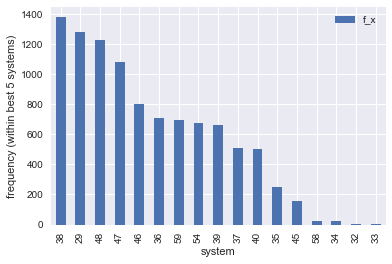

In [20]:
s_ranks = msmallest.sort_values("f_x", ascending=False)
ax= s_ranks.plot(x=s_ranks.index, y='f_x', kind='bar')
ax.set_ylabel('frequency (within best 5 systems)')

plt.show()

### Rerunning the comparisons with smaller subset

In [21]:
subset_indexes = msmallest.index.values.tolist()
#zero indexed
subset_indexes_zero = [x - 1 for x in subset_indexes]

subset = cf.subset_of_list(boot_data, subset_indexes_zero)


In [22]:
args.nscenarios = len(subset)
args.summary_func = bs.proportion_x2_lessthan_x1
#args.summary_func = bs.proportion_x2_greaterthan_x1
results = bs.compare_scenarios_pairwise(subset, args) 
matrix = io.results_to_matrix(results) 
io.insert_inverse_results(matrix, args.nscenarios)

In [23]:
df_subset = cf.matrix_to_dataframe(matrix, [str(i) for i in subset_indexes])
df_subset.style.applymap(io.colour_cells_by_proportion)

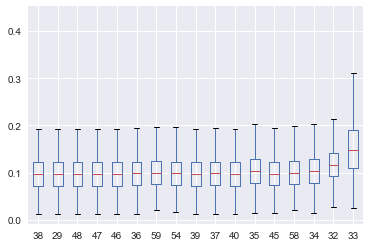

In [24]:
subset_indexes = msmallest.index.values.tolist()
ax = df_boots[subset_indexes].plot.box()